Emotive for LSL realtime

https://www.emotiv.com/blogs/tutorials/emotiv-lab-streaming-layer-lsl

FFT

https://github.com/KrishnaVeer7712/DIGITS-CLASSIFICATIONS-USING-ELECTROENCEPHALOGRAPHY-SIGNALS/blob/master/Brain_123%20(1).ipynb

https://github.com/ayushayt/ImaginedSpeechRecognition

In [1]:
import pandas as pd
import numpy as np


data_path = "data/emotiv/EP1.01.txt"

df_emotiv = pd.read_csv(data_path, sep='\t', header=None)



In [2]:
df_emotiv.columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
df_emotiv['data'] = df_emotiv['data'].apply(lambda x: list(map(float, x.split(','))))
df_emotiv.head()

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.384615, 4382.564102, 4377.435897, 4387.1..."
1,67636,67635,EP,F7,6,260,"[4489.230769, 4475.384615, 4474.358974, 4486.6..."
2,67637,67635,EP,F3,6,260,"[4538.461538, 4528.717948, 4524.615384, 4526.1..."
3,67638,67635,EP,FC5,6,260,"[4207.692307, 4205.641025, 4200.51282, 4194.35..."
4,67639,67635,EP,T7,6,260,"[4497.948717, 4498.461538, 4494.871794, 4497.9..."


In [28]:
df_emotiv["code"].value_counts()

code
 3    92652
 5    91994
 9    91882
 8    91728
 6    91322
 0    91224
 2    90930
 1    88914
 4    88886
 7    88718
-1     2226
Name: count, dtype: int64

In [3]:
df_emotiv["code"].unique()

array([ 6,  7,  9,  0,  8,  5,  3,  4,  2,  1, -1])

In [4]:
df_emotiv[df_emotiv["code"] == -1].shape[0]

2226

In [5]:
from scipy.signal import resample

def resample_signal(signal, original_rate, target_rate=128):
    num_samples = int(len(signal) * target_rate / original_rate)
    return resample(signal, num_samples)

# Sampling rates of each device
sampling_rates = {
    'MW': 512,  # MindWave
    'EP': 128,  # Emotiv Epoc
    'MU': 220,  # Interaxon Muse / Muse 2
    'IN': 128   # Emotiv Insight
}

# Resample the 'data' column for each device
def resample_device_data(df, device):
    original_rate = sampling_rates[device]
    df["data"] = df["data"].apply(lambda x: resample_signal(x, original_rate))
    return df

df_emotiv = resample_device_data(df_emotiv, 'EP')

In [6]:
df_emotiv_copy = pd.concat([df_emotiv.drop(['data'], axis=1), df_emotiv['data'].apply(pd.Series)], axis=1)

In [7]:
df_emotiv_copy.head()

,id,event,device,channel,code,size,0,1,2,3,...,310,311,312,313,314,315,316,317,318,319
0,67635,67635,EP,AF3,6,260,4395.384615,4382.564102,4377.435897,4387.179487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67636,67635,EP,F7,6,260,4489.230769,4475.384615,4474.358974,4486.666666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67637,67635,EP,F3,6,260,4538.461538,4528.717948,4524.615384,4526.153846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67638,67635,EP,FC5,6,260,4207.692307,4205.641025,4200.512820,4194.358974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67639,67635,EP,T7,6,260,4497.948717,4498.461538,4494.871794,4497.948717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# "data" column is an array of floats get the max length of the array
max_len = df_emotiv["data"].apply(len).max()
print(max_len)

# check the max number in the copied dataframe
print(df_emotiv_copy.columns[-1])
assert max_len == df_emotiv_copy.columns[-1] + 1

320
319


In [9]:
df_emotiv_copy["channel"].unique()

array(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8',
       'FC6', 'F4', 'F8', 'AF4'], dtype=object)

In [10]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Initialize MinMaxScaler for each EEG channel
scalers = {
    "AF3": MinMaxScaler(),
    "F7": MinMaxScaler(),
    "F3": MinMaxScaler(),
    "FC5": MinMaxScaler(),
    "T7": MinMaxScaler(),
    "P7": MinMaxScaler(),
    "O1": MinMaxScaler(),
    "O2": MinMaxScaler(),
    "P8": MinMaxScaler(),
    "T8": MinMaxScaler(),
    "FC6": MinMaxScaler(),
    "F4": MinMaxScaler(),
    "F8": MinMaxScaler(),
    "AF4": MinMaxScaler()
}

# get columns that are not string
crucial_columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'is_num']

# get non crucial columns
non_crucial_columns = [col for col in df_emotiv_copy.columns if col not in crucial_columns]

# Create a new DataFrame with the scaled and filtered data
df_emotiv_scaled = df_emotiv_copy.copy()

for channel in scalers.keys():
    sclaed_data = scalers[channel].fit_transform(df_emotiv_scaled.loc[df_emotiv_scaled["channel"] == channel, non_crucial_columns])
    df_emotiv_scaled.loc[df_emotiv_scaled["channel"] == channel, non_crucial_columns] = sclaed_data

# Save all scalers in one .pkl file
joblib.dump(scalers, "all_muse_channel_scalers.pkl")


['all_muse_channel_scalers.pkl']

In [11]:
df_emotiv_scaled.head()

,id,event,device,channel,code,size,0,1,2,3,...,310,311,312,313,314,315,316,317,318,319
0,67635,67635,EP,AF3,6,260,0.592058,0.589073,0.587879,0.590147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67636,67635,EP,F7,6,260,0.613908,0.610684,0.610445,0.613311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67637,67635,EP,F3,6,260,0.311219,0.306348,0.305765,0.307864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67638,67635,EP,FC5,6,260,0.548357,0.547880,0.546686,0.545253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67639,67635,EP,T7,6,260,0.615938,0.616057,0.615221,0.615938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_emotiv_scaled[non_crucial_columns].max()

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
315    0.0
316    0.0
317    0.0
318    0.0
319    0.0
Length: 320, dtype: float64

In [13]:
df_emotiv_scaled.isnull().sum().sum()

np.int64(55072962)

In [14]:
# this gives the null values of each column
l=df_emotiv_scaled.isnull().sum()
c=0
col_idx = 0
for i in l:
  c=c+1
  if(i!=0):
    print(c, i)
    print(df_emotiv_scaled[column].isnull().sum())
    break
  column = df_emotiv_scaled.columns[c-1]
  col_idx = c-1
print(column)

if col_idx != 0:
  cols_to_remove = range(col_idx, len(df_emotiv_scaled.columns))

  df_emotiv_scaled.drop(df_emotiv_scaled.columns[cols_to_remove], axis=1, inplace=True)

  df_emotiv_scaled.head()


143 14
0
135


In [17]:
df_emotiv_scaled.isnull().sum().sum()

np.int64(0)

In [18]:
print(df_emotiv_scaled["channel"].unique())

['AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8' 'T8' 'FC6' 'F4' 'F8' 'AF4']


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
(65034, 135)


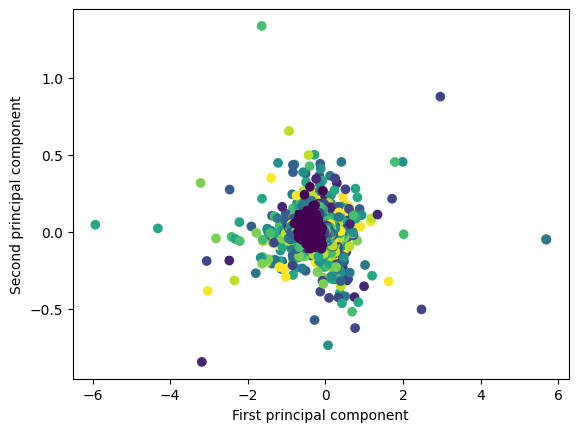

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# get the data between -1 and non -1 values
# Filter with .copy() to avoid SettingWithCopyWarning
non_minus_1 = df_emotiv_scaled[df_emotiv_scaled["code"] != -1].copy()
minus_1 = df_emotiv_scaled[df_emotiv_scaled["code"] == -1].copy()

channel = "AF4"
# Get tp9 data and create copies
non_minus_1_tp9 = non_minus_1[non_minus_1["channel"] == channel].copy()
minus_1_tp9 = minus_1[minus_1["channel"] == channel].copy()

# Set values
non_minus_1_tp9["is_num"] = 1
minus_1_tp9["is_num"] = 0

all_tp9 = pd.concat([non_minus_1_tp9, minus_1_tp9])


predictor_columns = [col for col in all_tp9.columns if col not in crucial_columns]
print(predictor_columns)
# now we will plot the pca of the data by 0 and 1
pca = PCA(n_components=2)

X = all_tp9[predictor_columns].values
y_binary = all_tp9["is_num"].values
y_code = all_tp9["code"].values


X_pca = pca.fit_transform(X)
print(X.shape)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_code, cmap='viridis')
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_code, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()


In [24]:
predictor_columns

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134]

In [21]:
channel_order = df_emotiv_scaled["channel"].unique()
channel_order

array(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8',
       'FC6', 'F4', 'F8', 'AF4'], dtype=object)

In [27]:
# all_tp9
# get value count of code frequencies
all_tp9["code"].value_counts()

code
 3    6618
 5    6571
 9    6563
 8    6552
 6    6523
 0    6516
 2    6495
 1    6351
 4    6349
 7    6337
-1     159
Name: count, dtype: int64

In [ ]:
event_unique = all_tp9["event"].unique()
print(len(event_unique))

65034


In [61]:
channel_order

array(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8',
       'FC6', 'F4', 'F8', 'AF4'], dtype=object)

In [66]:
af3 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "AF3"]
f7 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "F7"]
f3 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "F3"]
fc5 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "FC5"]
t7 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "T7"]
p7 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "P7"]
o1 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "O1"]
o2 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "O2"]
p8 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "P8"]
t8 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "T8"]
fc6 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "FC6"]
f4 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "F4"]
f8 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "F8"]
af4 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "AF4"]

print(af3.shape, f7.shape, f3.shape, fc5.shape, t7.shape, p7.shape, o1.shape, o2.shape, p8.shape, t8.shape, fc6.shape, f4.shape, f8.shape, af4.shape)

(65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141)


In [87]:
X = []
X_uncat = []
y = []

for i in range(0, len(af3)):
    af3_v = af3.iloc[i][predictor_columns].values
    f7_v = f7.iloc[i][predictor_columns].values
    f3_v = f3.iloc[i][predictor_columns].values
    fc5_v = fc5.iloc[i][predictor_columns].values
    t7_v = t7.iloc[i][predictor_columns].values
    p7_v = p7.iloc[i][predictor_columns].values
    o1_v = o1.iloc[i][predictor_columns].values
    o2_v = o2.iloc[i][predictor_columns].values
    p8_v = p8.iloc[i][predictor_columns].values
    t8_v = t8.iloc[i][predictor_columns].values
    fc6_v = fc6.iloc[i][predictor_columns].values
    f4_v = f4.iloc[i][predictor_columns].values
    f8_v = f8.iloc[i][predictor_columns].values
    af4_v = af4.iloc[i][predictor_columns].values
    
    X.append(np.concatenate((af3_v, f7_v, f3_v, fc5_v, t7_v, p7_v, o1_v, o2_v, p8_v, t8_v, fc6_v, f4_v, f8_v, af4_v)))
    X_uncat.append([af3_v, f7_v, f3_v, fc5_v, t7_v, p7_v, o1_v, o2_v, p8_v, t8_v, fc6_v, f4_v, f8_v, af4_v])
    if af3.iloc[i]["code"] == -1:
        y.append(10)
    else:
        y.append(af3.iloc[i]["code"])

In [89]:
X = np.array(X, dtype=np.float32)
X_uncat = np.array(X_uncat, dtype=np.float32)
X_uncat = X_uncat.transpose(0, 2, 1)
y = np.array(y)
print(X.shape, y.shape, X_uncat.shape)

(65034, 1890) (65034,) (65034, 135, 14)


In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize the RandomForest model
rf = RandomForestClassifier(n_estimators=100)

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5)


# X should have all 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

print(predictions)

KeyboardInterrupt: 

In [72]:
# save rf model
joblib.dump(rf, "rf_model_emotiv_1890.pkl")

['rf_model_emotiv_1890.pkl']

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F


X_train, X_test, y_train, y_test = train_test_split(X_uncat, y, test_size=0.2, random_state=42)
# X_train = X_train.transpose(0, 2, 1)
# X_test = X_test.transpose(0, 2, 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



# Define the PyTorch model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(14)  # Channels should match input shape
        self.conv1 = nn.Conv1d(14, 128, kernel_size=10, stride=1, padding='same')
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(128, 11)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Switch to (batch, channels, sequence)
        x = self.batch_norm1(x)
        x = F.relu(self.conv1(x))
        x = self.batch_norm2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # Reorder for LSTM (batch, sequence, input_size)
        x, _ = self.lstm(x)
        x = self.batch_norm3(x[:, -1, :])  # Use the last LSTM output
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)
        return F.log_softmax(x, dim=1)


(52027, 135, 14) (52027,) (13007, 135, 14) (13007,)


In [95]:
# Instantiate model, define loss and optimizer
model = EEGNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping criteria
best_accuracy = 0
patience = 10
trigger_times = 0


# Training loop
for epoch in range(5):
    model.train()
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_tensor)
        val_loss = criterion(val_outputs, y_train_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_train_tensor.numpy(), val_preds.numpy())
        print(f"Epoch {epoch+1}, Validation Accuracy: {val_accuracy}")

        # Early stopping logic
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping")
                break


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the adapted model with Conv1D, LSTM, and Dense layers
# Example LSTM model



class BrainWaveLSTM(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size, num_layers=1):
        super(BrainWaveLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step's output
        out = self.fc(out[:, -1, :])
        return out



In [71]:
accuracy_score(y_test, predictions)

0.11147843468901361

In [ ]:
# save the model